## 52 - Projection Magic

[Youtube](https://www.youtube.com/watch?v=7YH-M7MSRF4)

In [1]:
from datetime import datetime
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
import matplotlib.pyplot as plt
from matplotlib import patheffects
import metpy
from metpy.plots import add_metpy_logo, colortables
import xarray as xr
from xarray.backends import NetCDF4DataStore

%matplotlib inline

In [2]:
date = datetime.utcnow()
channel = 8
region = 'CONUS'

In [3]:
cat = TDSCatalog('http://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/{}/Channel{:02d}/{:%Y%m%d}/catalog.xml'.format(region, channel, date))

In [4]:
cat.datasets[-5:]

[OR_ABI-L2-CMIPC-M6C08_G16_s20233031441170_e20233031441170_c20233031441170.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20233031446170_e20233031446170_c20233031446170.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20233031451170_e20233031451170_c20233031451170.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20233031456170_e20233031456170_c20233031456170.nc,
 OR_ABI-L2-CMIPC-M6C08_G16_s20233031501170_e20233031501170_c20233031501170.nc]

In [5]:
ds = cat.datasets[-1]
ds = ds.remote_access(service = 'OPENDAP')

In [6]:
ds = NetCDF4DataStore(ds)
ds = xr.open_dataset(ds)

In [7]:
ds

<xarray.Dataset>
Dimensions:               (y: 1500, x: 2500)
Coordinates:
    time                  datetime64[ns] ...
  * y                     (y) float64 1.282e+05 1.282e+05 ... 4.427e+04
  * x                     (x) float64 -1.013e+05 -1.013e+05 ... 3.861e+04
Data variables:
    fixedgrid_projection  int32 ...
    Sectorized_CMI        (y, x) float32 ...
Attributes: (12/30)
    title:                       Sectorized Cloud and Moisture Imagery for th...
    ICD_version:                 GROUND SEGMENT (GS) TO ADVANCED WEATHER INTE...
    Conventions:                 CF-1.6
    channel_id:                  8
    central_wavelength:          6.19
    abi_mode:                    6
    ...                          ...
    pixel_y_size:                2.0
    satellite_latitude:          0.0
    satellite_longitude:         -75.0
    satellite_altitude:          35786023.0
    created_by:                  ldm-alchemy
    product_tiles_received:      15

In [8]:
dat = ds.metpy.parse_cf('Sectorized_CMI')
proj = dat.metpy.cartopy_crs

In [9]:
dat

<xarray.DataArray 'Sectorized_CMI' (y: 1500, x: 2500)>
[3750000 values with dtype=float32]
Coordinates:
    time       datetime64[ns] ...
  * y          (y) float64 4.588e+06 4.586e+06 4.584e+06 ... 1.586e+06 1.584e+06
  * x          (x) float64 -3.626e+06 -3.624e+06 ... 1.38e+06 1.382e+06
    metpy_crs  object Projection: geostationary
Attributes:
    standard_name:                                          brightness_temper...
    units:                                                  kelvin
    grid_mapping:                                           fixedgrid_projection
    valid_min:                                              0
    valid_max:                                              4095
    percent_good_pixel_qf:                                  1.0
    percent_conditionally_usable_pixel_qf:                  0.0
    percent_out_of_range_pixel_qf:                          0.0
    percent_no_value_pixel_qf:                              0.0
    percent_focal_plane_temperature_threshold_exceeded_qf:  0.0
    maximum_focal_plane_temperature:                        59.835674
    _ChunkSizes:                                            [512 512]

In [10]:
proj

<Derived Projected CRS: +proj=geos +a=6378137.0 +b=6356752.31414 +lon_0=-7 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Geostationary Satellite (Sweep X)
Datum: unknown
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

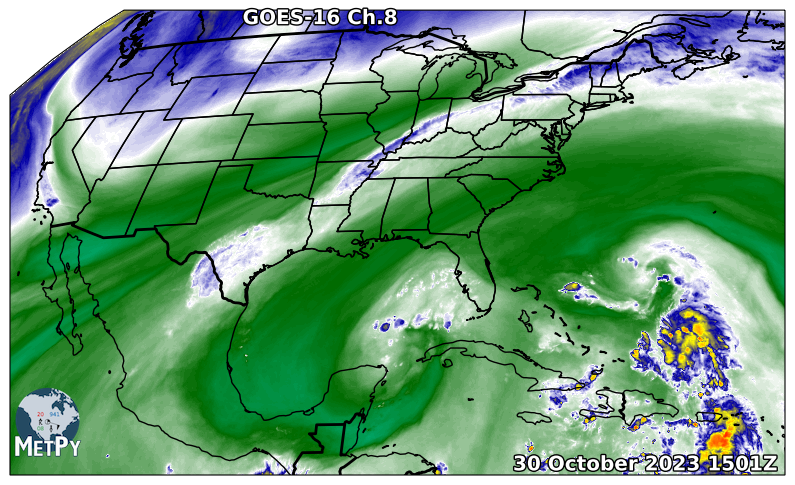

In [11]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1, projection = proj)

im = ax.imshow(dat, extent = (dat['x'].min(), dat['x'].max(), dat['y'].min(), dat['y'].max()), origin = 'upper')

wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS', 195, 265)
im.set_cmap(wv_cmap)
im.set_norm(wv_norm)

ax.add_feature(cfeature.BORDERS, linewidth = 2, edgecolor = 'black')
ax.add_feature(cfeature.STATES, edgecolor = 'black')
ax.coastlines(resolution = '50m', color = 'black')

timestamp = datetime.strptime(ds.start_date_time, '%Y%j%H%M%S')

text_time = ax.text(0.99, 0.01, timestamp.strftime('%d %B %Y %H%MZ'), horizontalalignment = 'right', transform = ax.transAxes, color = 'white', fontsize = 'x-large', weight = 'bold')

text_channel = ax.text(0.5, 0.97, 'GOES-16 Ch.{}'.format(channel), horizontalalignment = 'right', transform = ax.transAxes, color = 'white', fontsize = 'x-large', weight = 'bold')

outline_effect = [patheffects.withStroke(linewidth = 2, foreground = 'black')]
text_time.set_path_effects(outline_effect)
text_channel.set_path_effects(outline_effect)

add_metpy_logo(fig)